## Code to download real-time solar wind data and calculate magnetopause distance

We use pressure balance at the magnetopause, $2\rho v^2 = B^2 / 2\mu_0$, and insert the expression for a dipole magnetic field for $B$: 

$B(\theta = 90^\circ)=B_0\left(\frac{R_E}{r}\right)^3$

This implies that 

$B_0^2\left(\frac{R_E}{r}\right)^6/2\mu_0 = 2\rho v^2 \Rightarrow \left(\frac{R_E}{r}\right)^6 = \frac{4\mu_0\rho v^2}{B_0^2}$

so that the magnetopause distance in units of $R_E$ becomes

$r[R_E] = \left(\frac{B_0^2}{4\mu_0\rho v^2}\right)^{1/6}$



##### Update:
According to Wikipedia (!), the magnetic field just inside the magnetopause should be *twice* the dipole value. And in that case, the expression becomes

$r[R_E] = \left(\frac{B_0^2}{\mu_0\rho v^2}\right)^{1/6}$

Note: Also according to Wikipedia, the pressure term should not have the factor of 2. But let's ignore that...

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import pandas as pd

# constants
mu0 = 4 * np.pi * 1e-7
RE = 6371.2e3 # m
B0 = 3.12e-5 # T
mi = 1.67e-27 # kg

# define a function to calculate magnetopause distance in units of RE
def get_magnetopause_distance(n, v, mi = mi, B0 = B0):
    rho = mi * n

    r_RE = (B0**2 / (mu0 * rho * v**2))**(1/6)
    
    return(r_RE)

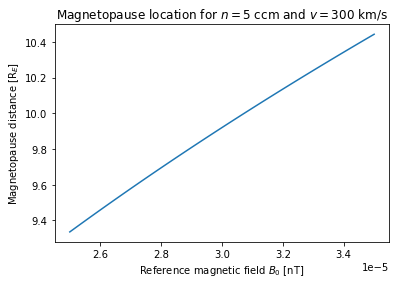

In [26]:
# input
v = 300e3 # m/s
n = 5e6 # particles per m^3

B0 = np.linspace(2.5e-5, 3.5e-5, 100) # 100 values ranging from 2.5e-5 to 3.5e-5

fig, ax = plt.subplots()
ax.plot(B0, get_magnetopause_distance(n, v, B0 = B0))
ax.set_xlabel('Reference magnetic field $B_0$ [nT]')
ax.set_ylabel('Magnetopause distance [R$_E$]')
ax.set_title(u'Magnetopause location for $n=${:.0f} ccm and $v=${:.0f} km/s'.format(n*1e-6, v*1e-3))
plt.show()

Text(0, 0.5, 'Wrong (?) magnetopause distance [R$_E$]')

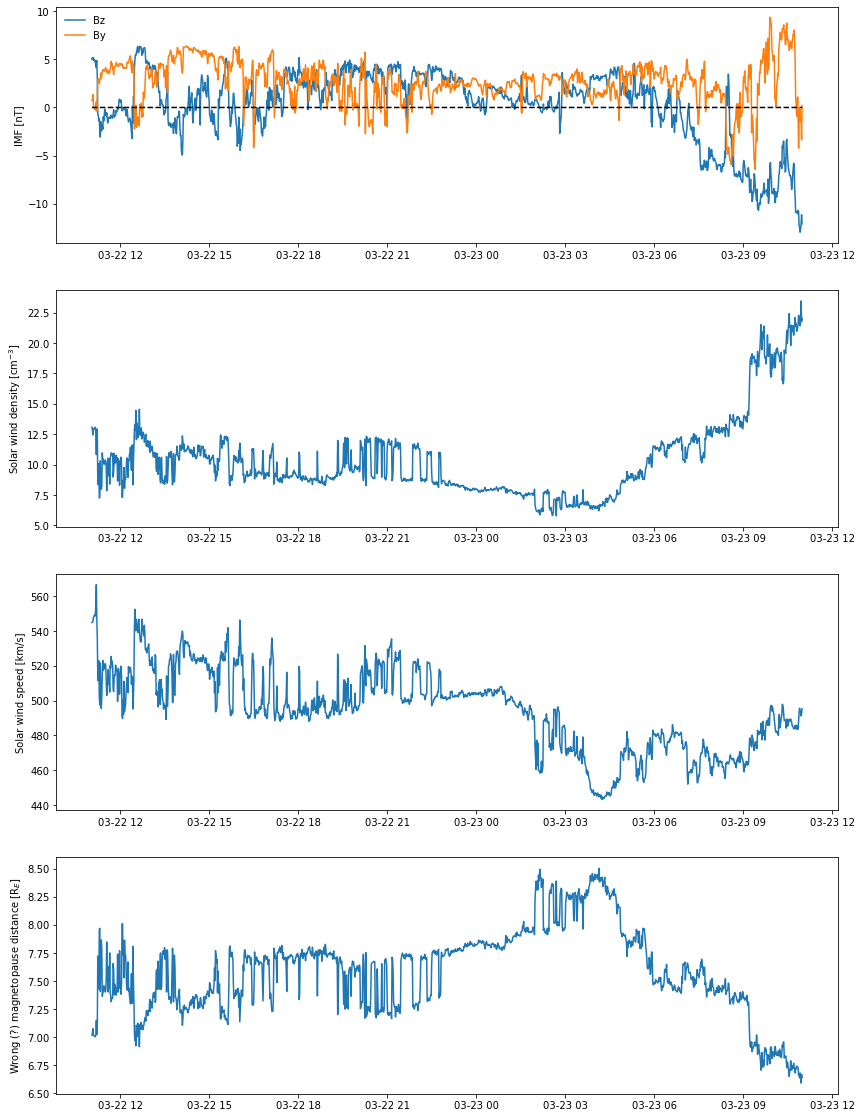

In [27]:
# a function to get real-time solar wind data:

def get_solar_wind_data(plasma_url = 'https://services.swpc.noaa.gov/products/solar-wind/plasma-1-day.json',
                        imf_url    = 'https://services.swpc.noaa.gov/products/solar-wind/mag-1-day.json'):
    """ download latest solar wind data, and return a dataframe containing solar wind data from the previous 7 days. 
        The index of the dataframe will be minutes compared to current tine
    """

    # download and read with pandas:
    try:
        plasma_response = urllib.request.urlopen(plasma_url)
        plasma = pd.read_json(plasma_response.read())
    except:
        print('Could not download and read %s' % plasma_url)
        return 0
    try:
        imf_response    = urllib.request.urlopen(imf_url   )
        imf    = pd.read_json(imf_response.read()   )
    except:
        print('Could not donwload and read %s' % imf_url)
        return 0

    # format output and index by datetime
    plasma.columns = plasma.loc[0, :]
    imf   .columns = imf   .loc[0, :]

    plasma = plasma[1:]
    imf    = imf   [1:]

    plasma.index = pd.DatetimeIndex(plasma['time_tag'])
    imf   .index = pd.DatetimeIndex(imf   ['time_tag'])

    # resample to 1 min and fill in
    plasma = plasma.resample('1Min').nearest(limit = 2)[['speed', 'density']]
    imf    = imf.resample('1Min').nearest(limit = 2)[['by_gsm', 'bz_gsm']]

    # merge the dataframes
    external = pd.concat((plasma, imf), axis = 1)

    # change index and column names
    external.index.name = 'time'
    external.columns = ['v', 'density', 'by', 'bz']

    return external.astype(np.float64)

sw_data = get_solar_wind_data()



fig, axes = plt.subplots(nrows = 4, figsize = (14, 20))
axes[0].plot(sw_data.index, sw_data.bz, label = 'Bz')
axes[0].plot(sw_data.index, sw_data.by, label = 'By')
axes[0].set_ylabel('IMF [nT]')
axes[0].legend(frameon = False)
axes[0].plot(sw_data.index, sw_data.bz*0, 'k--')

axes[1].plot(sw_data.index, sw_data.density)
axes[1].set_ylabel('Solar wind density [cm$^{-3}$]')

axes[2].plot(sw_data.index, sw_data.v)
axes[2].set_ylabel('Solar wind speed [km/s]')

r = get_magnetopause_distance(sw_data['density'] * 1e6, sw_data['v'] * 1e3)
axes[3].plot(sw_data.index, r)
axes[3].set_ylabel('Wrong (?) magnetopause distance [R$_E$]')

